# Tiền xử lý User

In [17]:
# Cell 1 — Import & cấu hình
import pandas as pd
import numpy as np
import json
from pathlib import Path
from joblib import dump
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# --------------------------
# Config
# --------------------------
LOW_CARD_DEFAULT_THRESHOLD = 20
IQR_FACTOR = 1.5

USER_DROP_ALWAYS = [
    "sync_error_message", "sync_status_id", "last_sync_date",
    "updated_date", "timestamp", "is_deleted"
]

OBJ_EXCLUDE = []  # free-text cột sẽ không mã hóa


: 

In [ ]:
# Cell 2 — Đọc dữ liệu parquet, lọc theo pattern và lưu ra file CSV
from pathlib import Path
import pandas as pd

def read_all_parquet(dataset_dir: str, pattern: str = "*.parquet", out_csv: str = "raw_items.csv"):
    dataset = Path(dataset_dir)
    
    # Tìm tất cả các file parquet phù hợp pattern và chứa 'item_chunk'
    all_files = sorted([
        p for p in dataset.rglob("*.parquet")
        if ("user_chunk" in p.name.lower() and p.match(pattern))
    ])

    if not all_files:
        raise FileNotFoundError(
            f"No item parquet found in '{dataset_dir}' matching pattern '{pattern}'"
        )

    print(f"📁 Found {len(all_files)} item chunk(s) in '{dataset_dir}'")
    
    # Đọc và gộp các file
    df_raws = [pd.read_parquet(f) for f in all_files]
    combined = pd.concat(df_raws, ignore_index=True)
    print(f"✅ Combined shape: {combined.shape}")

    # Lưu dữ liệu gốc ra CSV để tham khảo
    combined.to_csv(out_csv, index=False)
    print(f"💾 Raw data saved to: {out_csv}")

    return combined

# --- Ví dụ sử dụng ---
input_dir = r"C:\Users\Tin\Downloads\recommendation dataset"
df = read_all_parquet(input_dir, pattern="*.parquet", out_csv="raw_items.csv")

📁 Found 10 item chunk(s) in 'C:\Users\Tin\Downloads\recommendation dataset'


# Task 1: Loại bỏ các đặc trưng không cần thiết

In [ ]:
# Cell 3 — Task 1: Drop meta/system columns & ưu tiên user_id
drop_report = {}

to_drop = [c for c in USER_DROP_ALWAYS if c in df.columns]
if to_drop:
    df = df.drop(columns=to_drop)
    drop_report["dropped_system_meta"] = to_drop

if "customer_id" in df.columns and "user_id" in df.columns:
    df = df.drop(columns=["customer_id"])
    drop_report["dropped_customer_id"] = True

print("✅ Task 1 done.")
print(f"Remaining columns ({len(df.columns)}): {list(df.columns)}")
df.head()


✅ Task 1 done.
Remaining columns (11): ['gender', 'location', 'province', 'membership', 'created_date', 'region', 'location_name', 'install_app', 'install_date', 'district', 'user_id']


,gender,location,province,membership,created_date,region,location_name,install_app,install_date,district,user_id
0,Nam,155,Hồ Chí Minh,Standard,2011-05-25 21:11:51.677,Đông Nam Bộ,HCM - Grand View Phú Mỹ Hưng,In-Store,1306281600,7,e1e48206652bf8c279ff0206c69a80dd5f19653569f0df...
1,Nữ,300,Hồ Chí Minh,Standard,2011-05-25 21:11:51.677,Đông Nam Bộ,HCM - 121A Nguyễn Duy Trinh,In-Store,1306281600,Thủ Đức,77891759204bd27e69fb11a7b92889aae74b50fc88105c...
2,Nữ,157,Bến Tre,Standard,2011-07-31 15:38:12.750,Đồng bằng sông Cửu Long,BTR - 179 Nguyễn Đình Chiểu,In-Store,1582070400,Bến Tre,b8041b584a0bb6655361727a0a61084a03ccf2c4dbce9d...
3,Nữ,53,Hồ Chí Minh,Standard,2011-08-25 20:06:22.797,Đông Nam Bộ,HCM - 101 Trần Quang Khải,In-Store,1314230400,1,c52ceaca44a83ec41a219cfaff0e05ae218a0c15a59d65...
4,Nữ,660,Hồ Chí Minh,Standard,2011-08-25 22:07:04.267,Đông Nam Bộ,HCM - 85-87 Tây Thạnh,In-Store,1314230400,Tân Phú,74ac5764f5d67d341aacf238d7762f00e1c3dd45439133...


# Task 2: Xử lý NULL và Outlier

In [ ]:
# Cell 4 — Task 2: Xử lý NULL và Outlier
def clip_iqr(series, factor=1.5):
    if series.isna().all():
        return series
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - factor * iqr, q3 + factor * iqr
    return series.clip(lower, upper)

for c in df.select_dtypes(include=["object"]).columns:
    if df[c].isna().any():
        df[c] = df[c].fillna("Unknown")

for c in df.select_dtypes(include=[np.number]).columns:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
        df[c] = clip_iqr(df[c], factor=IQR_FACTOR)

print("✅ Task 2 done: NULL & outlier handled.")
df.describe()


✅ Task 2 done: NULL & outlier handled.


,location,created_date,install_date
count,4.573964e+06,4573964,4.573964e+06
mean,5.540535e+02,2022-12-16 22:48:44.025646,1.684142e+09
min,4.200000e+01,2011-05-25 21:11:51.677000,1.306282e+09
25%,3.020000e+02,2021-10-15 10:09:33.315000,1.654992e+09
50%,5.470000e+02,2023-09-29 16:33:24.772000,1.705450e+09
75%,7.650000e+02,2024-11-09 14:38:25.891500,1.736640e+09
max,1.310000e+03,2025-09-30 22:00:36.623000,1.759190e+09
std,2.955234e+02,NaN,7.137426e+07


# Task 3: Phân tích tương đồng và loại bỏ đặc trưng thừa

C:\Users\Tin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


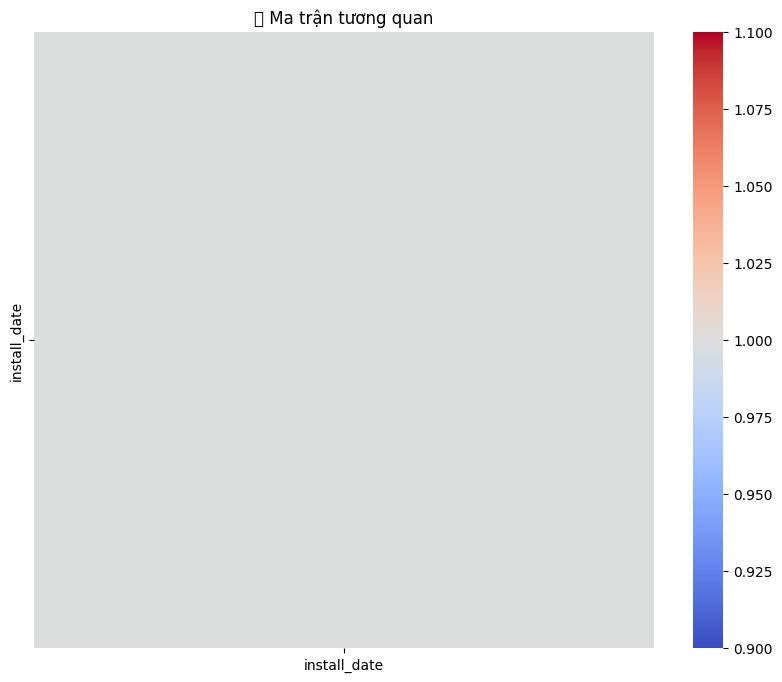

✅ Task 3 done.


In [ ]:
# Cell 5 — Task 3: Phát hiện numeric-categorical & lưu correlation
def is_id_or_ts_or_date(col: str) -> bool:
    c = col.lower()
    return (c.endswith("_id") or "timestamp" in c or "date" in c)

def detect_numeric_categoricals(df, max_ratio=0.001, max_abs=64):
    candidates = []
    n = max(1, len(df))
    for c in df.select_dtypes(include=[np.number]).columns:
        if is_id_or_ts_or_date(c):
            continue
        k = df[c].nunique(dropna=False)
        if (k / n) <= max_ratio or k <= max_abs:
            candidates.append(c)
    return candidates

num_as_cat = detect_numeric_categoricals(df)
drop_report["numeric_as_categorical_detected"] = num_as_cat
for c in num_as_cat:
    df[c] = df[c].astype("Int64").astype(str)

corr = df.select_dtypes(include=[np.number]).corr()
corr.to_csv("user_corr_report.csv")
print("💾 Saved correlation to user_corr_report.csv")
print("✅ Task 3 done.")


# Task 4: Chuẩn hóa dữ liệu

In [ ]:
# Cell 6 — Task 4: Scaling numeric + Encoding categorical
from sklearn.preprocessing import StandardScaler

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if not is_id_or_ts_or_date(c)]
obj_cols = [c for c in df.select_dtypes(include=["object"]).columns if c not in OBJ_EXCLUDE]

# Chuẩn hóa số
scaler = StandardScaler()
if num_cols:
    df[num_cols] = scaler.fit_transform(df[num_cols])

# Phân loại OHE hay Frequency encoding
global_cardinality = {c: df[c].nunique(dropna=False) for c in obj_cols}
ohe_cols = [c for c, k in global_cardinality.items() if k <= LOW_CARD_DEFAULT_THRESHOLD]
freq_cols = [c for c, k in global_cardinality.items() if k > LOW_CARD_DEFAULT_THRESHOLD]

# Frequency encoding
def frequency_encode(series):
    vc = series.value_counts(dropna=False)
    total = float(vc.sum()) or 1.0
    freq = {str(k): v / total for k, v in vc.items()}
    return series.astype(str).map(freq).fillna(0.0)

for c in freq_cols:
    df[c] = frequency_encode(df[c])

# One-hot encode
df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)

drop_report["ohe_cols"] = ohe_cols
drop_report["freq_cols"] = freq_cols

print(f"✅ Task 4 done: scaled {len(num_cols)} numeric cols, encoded {len(ohe_cols)} + {len(freq_cols)} categorical cols.")


✅ Task 4 done: scaled 0 numeric cols, encoded 4 + 5 categorical cols.


In [ ]:
# Cell 7 — Thống kê dữ liệu sau xử lý
print(f"Final shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")
df.head()


Final shape: (4573964, 28)
Columns (28): ['location', 'province', 'created_date', 'location_name', 'install_date', 'district', 'user_id', 'gender_Nam', 'gender_Nữ', 'membership_Gold', 'membership_Standard', 'region_Duyên hải Bắc Bộ', 'region_Duyên hải Nam Trung Bộ', 'region_Trung du và miền núi phía Bắc', 'region_Tây Nguyên', 'region_Đông Nam Bộ', 'region_Đồng bằng sông Hồng', 'region_Đồng bằng sông Cửu Long', 'install_app_CRM Partner', 'install_app_Call', 'install_app_Chat', 'install_app_In-Store', 'install_app_Không xác định', 'install_app_LZD', 'install_app_SPE', 'install_app_Web', 'install_app_Wholesale', 'install_app_iOS']


,location,province,created_date,location_name,install_date,district,user_id,gender_Nam,gender_Nữ,membership_Gold,...,install_app_CRM Partner,install_app_Call,install_app_Chat,install_app_In-Store,install_app_Không xác định,install_app_LZD,install_app_SPE,install_app_Web,install_app_Wholesale,install_app_iOS
0,0.001063,0.267456,2011-05-25 21:11:51.677,0.001063,1306281600,0.014334,2.186287e-07,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1,0.001274,0.267456,2011-05-25 21:11:51.677,0.001274,1306281600,0.042764,2.186287e-07,False,True,False,...,False,False,False,True,False,False,False,False,False,False
2,0.001993,0.009487,2011-07-31 15:38:12.750,0.001993,1582070400,0.003820,2.186287e-07,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,0.001713,0.267456,2011-08-25 20:06:22.797,0.001713,1314230400,0.014398,2.186287e-07,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,0.000819,0.267456,2011-08-25 22:07:04.267,0.000819,1314230400,0.022483,2.186287e-07,False,True,False,...,False,False,False,True,False,False,False,False,False,False


# Task 5: Rút trích thêm các đặc trưng

| Loại đặc trưng                                 | Ví dụ                                                         | Giải thích                                                                 |
| ---------------------------------------------- | ------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **Thời gian (temporal features)**              | `account_age_days` = `today - created_date`                   | Tuổi tài khoản càng lâu, khả năng mua hàng thường cao hơn.                 |
|                                                | `install_to_created_days` = `created_date - install_date`     | Khoảng thời gian giữa cài đặt và tạo tài khoản.                            |
|                                                | `is_weekend_user` = 1 nếu `created_date` rơi vào T7/CN        | Người dùng tạo tài khoản cuối tuần có hành vi khác biệt.                   |
| **Phân loại vùng địa lý**                      | `region_encoded` (0–6)                                        | Biến mã vùng định danh để dùng trong mô hình.                              |
|                                                | `urban_flag` = 1 nếu `province` thuộc TP lớn (HCM, HN, ĐN...) | Người dùng thành thị thường có hành vi mua hàng khác.                      |
| **Tần suất hành vi (nếu có dữ liệu mua hàng)** | `purchase_freq` = số lần mua / tháng                          | Cho biết độ trung thành.                                                   |
|                                                | `avg_spent` = tổng chi tiêu / số đơn hàng                     | Thước đo giá trị khách hàng.                                               |
| **Tương tác giữa đặc trưng**                   | `gender × membership` → “Nữ_Gold”, “Nam_Standard”             | Kết hợp giới tính & hạng thành viên có thể giúp phân biệt nhóm khách hàng. |
|                                                | `region × install_app`                                        | Một số vùng chuộng kênh mua hàng khác nhau.                                |


In [ ]:
# Cell 9 — Task 5: Feature Engineering
import pandas as pd
from datetime import datetime

print(f"Initial shape before feature engineering: {df.shape}")

# --- Thời gian ---
# Chuyển đổi định dạng ngày
for col in ["created_date", "install_date"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Tuổi tài khoản (ngày)
today = pd.Timestamp(datetime.now().date())
df["account_age_days"] = (today - df["created_date"]).dt.days

# Khoảng cách giữa install và created
df["install_to_created_days"] = (df["created_date"] - df["install_date"]).dt.days

# Người dùng tạo tài khoản cuối tuần
df["is_weekend_user"] = df["created_date"].dt.dayofweek.isin([5, 6]).astype(int)

# --- Đặc trưng vị trí ---
major_cities = ["Hồ Chí Minh", "Hà Nội", "Đà Nẵng", "Hải Phòng", "Cần Thơ"]
df["urban_flag"] = df["province"].isin(major_cities).astype(int)

# Mã hóa vùng (nếu cần mô hình số)
region_cols = df.filter(like="region_").columns.tolist()
region_map = {region: idx for idx, region in enumerate(region_cols, start=0)}
df["region_encoded"] = df.filter(like="region_").idxmax(axis=1)

# --- Tương tác giữa đặc trưng ---
# Kết hợp giới tính và hạng thành viên
def combine_onehot(row):
    gender = "Nam" if row.get("gender_Nam", 0) == 1 else "Nữ"
    membership = (
        "Gold" if row.get("membership_Gold", 0) == 1 else
        "Standard" if row.get("membership_Standard", 0) == 1 else "Unknown"
    )
    return f"{gender}_{membership}"

df["gender_membership_combo"] = df.apply(combine_onehot, axis=1)

print(f"✅ Feature engineering done. Final shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")

# Lưu kết quả
df.to_csv("processed_user_features.csv", index=False)
print("💾 Saved engineered features → processed_user_features.csv")


Initial shape before feature engineering: (4573964, 32)
✅ Feature engineering done. Final shape: (4573964, 34)
Columns (34): ['location', 'province', 'created_date', 'location_name', 'install_date', 'district', 'user_id', 'gender_Nam', 'gender_Nữ', 'membership_Gold', 'membership_Standard', 'region_Duyên hải Bắc Bộ', 'region_Duyên hải Nam Trung Bộ', 'region_Trung du và miền núi phía Bắc', 'region_Tây Nguyên', 'region_Đông Nam Bộ', 'region_Đồng bằng sông Hồng', 'region_Đồng bằng sông Cửu Long', 'install_app_CRM Partner', 'install_app_Call', 'install_app_Chat', 'install_app_In-Store', 'install_app_Không xác định', 'install_app_LZD', 'install_app_SPE', 'install_app_Web', 'install_app_Wholesale', 'install_app_iOS', 'account_age_days', 'install_to_created_days', 'is_weekend_user', 'urban_flag', 'region_encoded', 'gender_membership_combo']
💾 Saved engineered features → processed_user_features.csv


In [ ]:
df.head()

,location,province,created_date,location_name,install_date,district,user_id,gender_Nam,gender_Nữ,membership_Gold,...,install_app_SPE,install_app_Web,install_app_Wholesale,install_app_iOS,account_age_days,install_to_created_days,is_weekend_user,urban_flag,region_encoded,gender_membership_combo
0,0.001063,0.267456,2011-05-25 21:11:51.677,0.001063,1970-01-01 00:00:01.306281600,0.014334,2.186287e-07,True,False,False,...,False,False,False,False,5255,15119,0,0,region_Đông Nam Bộ,Nam_Standard
1,0.001274,0.267456,2011-05-25 21:11:51.677,0.001274,1970-01-01 00:00:01.306281600,0.042764,2.186287e-07,False,True,False,...,False,False,False,False,5255,15119,0,0,region_Đông Nam Bộ,Nữ_Standard
2,0.001993,0.009487,2011-07-31 15:38:12.750,0.001993,1970-01-01 00:00:01.582070400,0.003820,2.186287e-07,False,True,False,...,False,False,False,False,5188,15186,1,0,region_Đồng bằng sông Cửu Long,Nữ_Standard
3,0.001713,0.267456,2011-08-25 20:06:22.797,0.001713,1970-01-01 00:00:01.314230400,0.014398,2.186287e-07,False,True,False,...,False,False,False,False,5163,15211,0,0,region_Đông Nam Bộ,Nữ_Standard
4,0.000819,0.267456,2011-08-25 22:07:04.267,0.000819,1970-01-01 00:00:01.314230400,0.022483,2.186287e-07,False,True,False,...,False,False,False,False,5163,15211,0,0,region_Đông Nam Bộ,Nữ_Standard
